# Player Position Prediction

- Evaluating a football player's position based on their heatmap, to try and accurately predict their role as a player.

This project focuses on a sample event dataset generated by "Metrica-Sports", and we'll use the sample data that they have provided via Github.

In [65]:
#Cloning the sample data from Metrica-Sports Github
!git clone https://github.com/metrica-sports/sample-data.git

fatal: destination path 'sample-data' already exists and is not an empty directory.


In [66]:
#Core modules 
import pandas as pd
import numpy as np

# Matplot and seaborn to plot our data
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans

# mplsoccer will allow us to draw a proper football pitch to plot our data on.
from mplsoccer import Pitch

# System
import os

# Plot settings
sns.set(style="white", palette="muted")
plt.rcParams["figure.figsize"] = (10, 7)

In [67]:
# Load both team data files
game_1_home_team = pd.read_csv("sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv")
game_1_away_team = pd.read_csv("sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv")

# Preview to ensure data is collected
print("Home team data shape:", game_1_home_team.shape)
print("Away team data shape:", game_1_away_team.shape)
print("\nHome team preview:")
game_1_home_team.head()
game_1_away_team.head()

C:\Users\nshuh\AppData\Local\Temp\ipykernel_27756\1424203949.py:2: DtypeWarning: Columns (0,1,2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  game_1_home_team = pd.read_csv("sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv")


Home team data shape: (145008, 33)
Away team data shape: (145008, 33)

Home team preview:


C:\Users\nshuh\AppData\Local\Temp\ipykernel_27756\1424203949.py:3: DtypeWarning: Columns (0,1,2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  game_1_away_team = pd.read_csv("sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv")


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Away,Unnamed: 4,Away.1,Unnamed: 6,Away.2,Unnamed: 8,Away.3,...,Away.10,Unnamed: 24,Away.11,Unnamed: 26,Away.12,Unnamed: 28,Away.13,Unnamed: 30,Away.14,Unnamed: 32
0,NaN,NaN,NaN,25,NaN,15,NaN,16,NaN,17,...,24,NaN,26,NaN,27,NaN,28,NaN,NaN,NaN
1,Period,Frame,Time [s],Player25,NaN,Player15,NaN,Player16,NaN,Player17,...,Player24,NaN,Player26,NaN,Player27,NaN,Player28,NaN,Ball,NaN
2,1,1,0.04,0.90509,0.47462,0.58393,0.20794,0.67658,0.4671,0.6731,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
3,1,2,0.08,0.90494,0.47462,0.58393,0.20794,0.67658,0.4671,0.6731,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
4,1,3,0.12,0.90434,0.47463,0.58393,0.20794,0.67658,0.4671,0.6731,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.53716,0.42556


Generating our co-ordinates for the home and away team we can notice that the X and Y co-ordinates are between 0 and 1, indicating the football pitch such as a graph, allowing us to plot these exact co-ordinates on a generated football pitch to track each player. From our understanding we can assume (0,0) to be the top-left hand side of the pitch, and (1,1) to be the top-right side of the pitch, and any negative values would be events occuring off the pitch. 

In [68]:
#Sort out the X and Y co-ordinates for the home and away team
# Check the current column names (occur on row 3)
# Rereading the CSV file to skip the first 2 rows.
# Load with the third row as header (row index 2)
game_1_home_team = pd.read_csv("sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", header=2) 

game_1_away_team = pd.read_csv("sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", header=2)  
print("Home Team Columns:" , game_1_home_team.columns.tolist())
print("Home Team Columns:" , game_1_away_team.columns.tolist())

# Get example values of one player
game_1_home_team['Player1'].head(10)

Home Team Columns: ['Period', 'Frame', 'Time [s]', 'Player11', 'Unnamed: 4', 'Player1', 'Unnamed: 6', 'Player2', 'Unnamed: 8', 'Player3', 'Unnamed: 10', 'Player4', 'Unnamed: 12', 'Player5', 'Unnamed: 14', 'Player6', 'Unnamed: 16', 'Player7', 'Unnamed: 18', 'Player8', 'Unnamed: 20', 'Player9', 'Unnamed: 22', 'Player10', 'Unnamed: 24', 'Player12', 'Unnamed: 26', 'Player13', 'Unnamed: 28', 'Player14', 'Unnamed: 30', 'Ball', 'Unnamed: 32']
Home Team Columns: ['Period', 'Frame', 'Time [s]', 'Player25', 'Unnamed: 4', 'Player15', 'Unnamed: 6', 'Player16', 'Unnamed: 8', 'Player17', 'Unnamed: 10', 'Player18', 'Unnamed: 12', 'Player19', 'Unnamed: 14', 'Player20', 'Unnamed: 16', 'Player21', 'Unnamed: 18', 'Player22', 'Unnamed: 20', 'Player23', 'Unnamed: 22', 'Player24', 'Unnamed: 24', 'Player26', 'Unnamed: 26', 'Player27', 'Unnamed: 28', 'Player28', 'Unnamed: 30', 'Ball', 'Unnamed: 32']


0    0.32648
1    0.32648
2    0.32648
3    0.32622
4    0.32597
5    0.32581
6    0.32570
7    0.32564
8    0.32557
9    0.32551
Name: Player1, dtype: float64

As seen by the data extracted, the X-Coordinates are stored in the Player column, the unnamed column next to it is where the Y values are stored. For ease of extraction and cleaning data, we will rename our columns to "Player1_x" and "Player1_y", for each player and their correct number.

In [69]:
# Check the current column names first
print("Current columns:", game_1_home_team.columns.tolist())
print("Number of columns:", len(game_1_home_team.columns))

Current columns: ['Period', 'Frame', 'Time [s]', 'Player11', 'Unnamed: 4', 'Player1', 'Unnamed: 6', 'Player2', 'Unnamed: 8', 'Player3', 'Unnamed: 10', 'Player4', 'Unnamed: 12', 'Player5', 'Unnamed: 14', 'Player6', 'Unnamed: 16', 'Player7', 'Unnamed: 18', 'Player8', 'Unnamed: 20', 'Player9', 'Unnamed: 22', 'Player10', 'Unnamed: 24', 'Player12', 'Unnamed: 26', 'Player13', 'Unnamed: 28', 'Player14', 'Unnamed: 30', 'Ball', 'Unnamed: 32']
Number of columns: 33


In [70]:
#Rename the columns to relevant values
new_columns = []
column_names = game_1_home_team.columns.tolist()

i = 0
while i < len(column_names):
    column_name = column_names[i]
    if 'Player' or 'ball' in str(column_name):
        # Check if next column is unnamed
        if i + 1 < len(column_names):
            next_column = column_names[i + 1]
            if 'Unnamed' in str(next_column):
                new_columns.append(f"{column_name}_x")
                new_columns.append(f"{column_name}_y")
                i += 2  # Skip both the Player column and the Unnamed column
            else:
                new_columns.append(column_name)
                i += 1
        else:
            new_columns.append(column_name)
            i += 1
    else:
        new_columns.append(column_name)
        i += 1

# Check column names to ensure renaming has occurred
game_1_home_team.columns = new_columns
column_names = game_1_home_team.columns.tolist()
print(column_names)

['Period', 'Frame', 'Time [s]', 'Player11_x', 'Player11_y', 'Player1_x', 'Player1_y', 'Player2_x', 'Player2_y', 'Player3_x', 'Player3_y', 'Player4_x', 'Player4_y', 'Player5_x', 'Player5_y', 'Player6_x', 'Player6_y', 'Player7_x', 'Player7_y', 'Player8_x', 'Player8_y', 'Player9_x', 'Player9_y', 'Player10_x', 'Player10_y', 'Player12_x', 'Player12_y', 'Player13_x', 'Player13_y', 'Player14_x', 'Player14_y', 'Ball_x', 'Ball_y']


Having renamed the player co-ordinates for all players we can now accurately work with our data and start plotting it onto our generated pitch using the mplsoccer library.

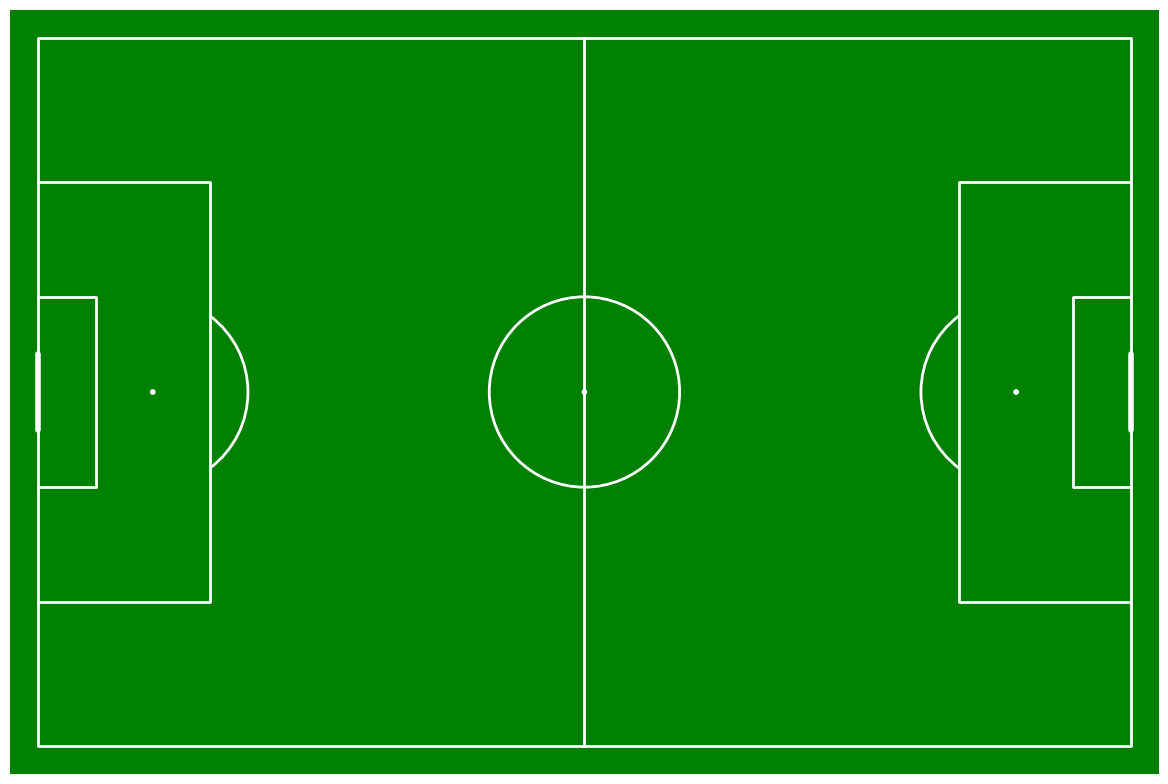

In [71]:
#Creating the pitch
player1_pitch = Pitch(pitch_type='metricasports', pitch_length=105, pitch_width=68, line_color='white', pitch_color='green')
fig, ax = player1_pitch.draw(figsize=(12,8))

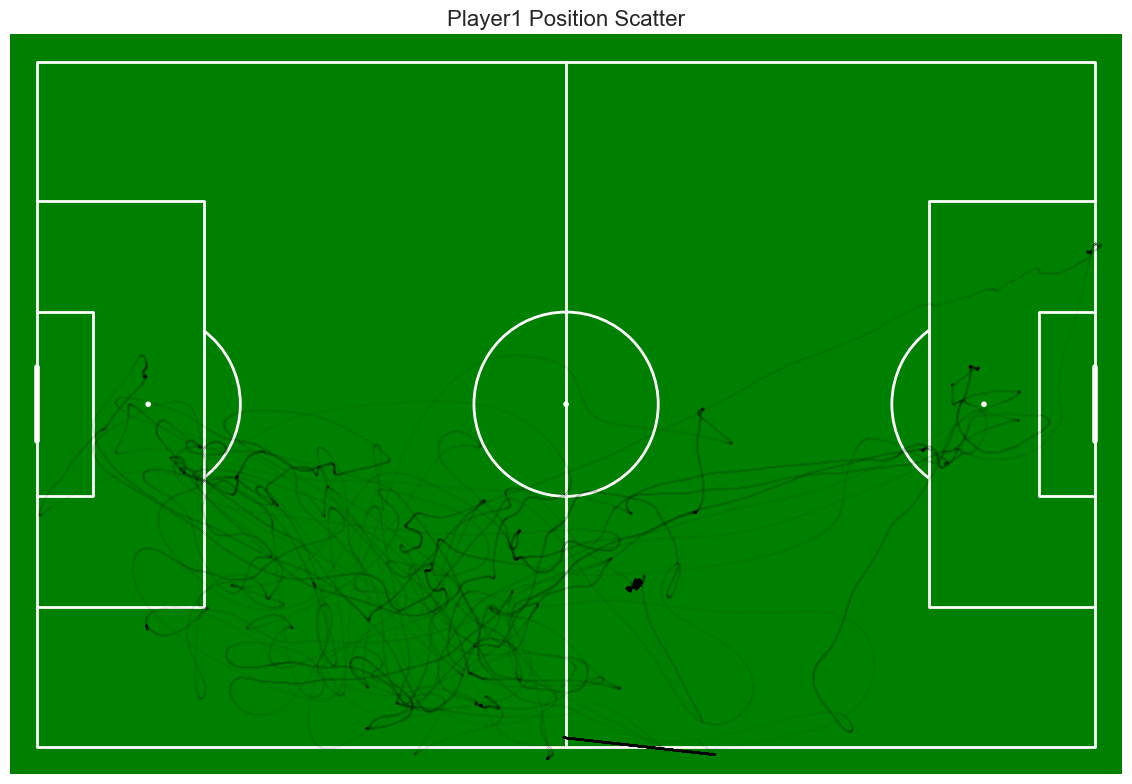

In [72]:
#Example extract co-ordinates for player1
player1_x_coords = game_1_home_team['Player1_x'].dropna()
player1_y_coords = game_1_home_team['Player1_y'].dropna()

#Plotting Player 1's position
player1_pitch.scatter(player1_x_coords, player1_y_coords, ax=ax, s=0.001, color='black', label='Player1')

# Add title
ax.set_title('Player1 Position Scatter', fontsize=16)

# Show the plot
plt.show()
display(fig)

Having successfully plotted Player 1's chart, we can now run a loop to create a figure for all players in the team.

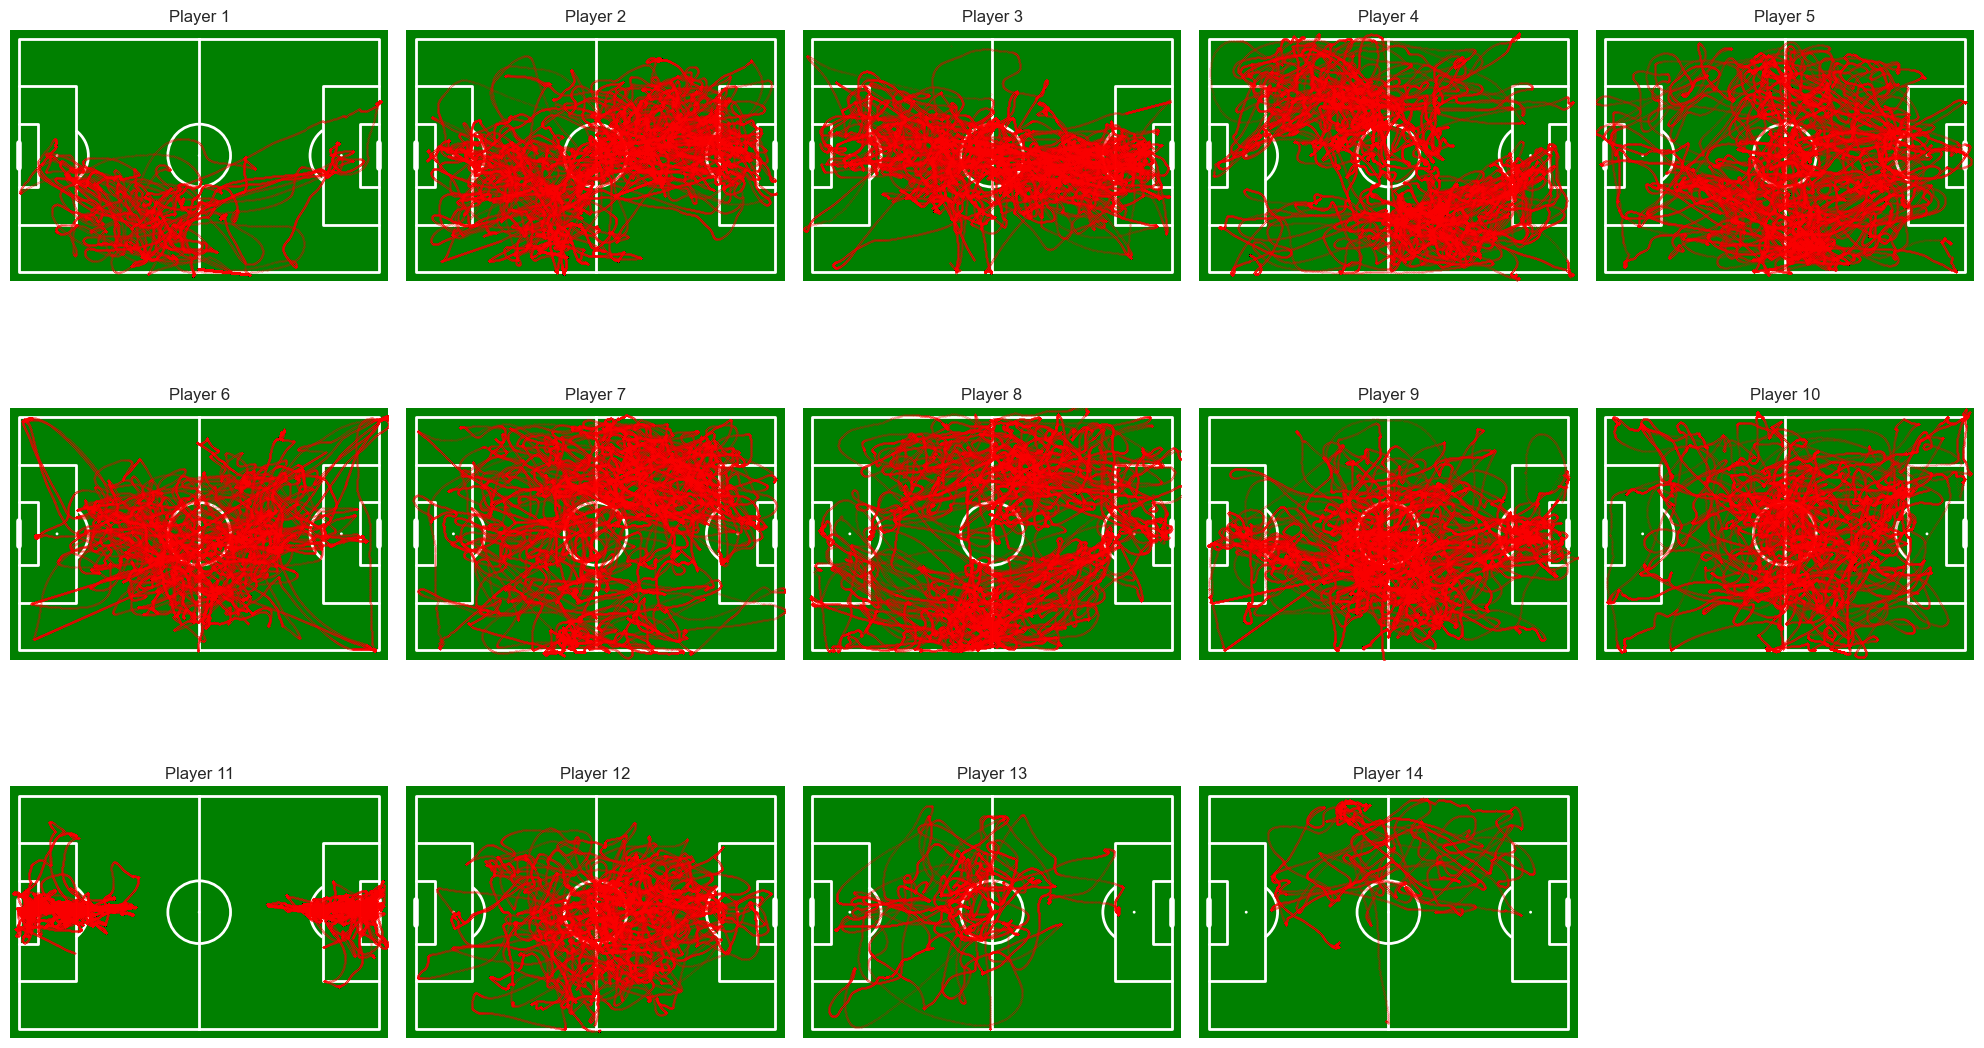

In [73]:
# Create subplots for each player
figure, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i in range(1, 15):  # Players 1-14
    try:
        # Create individual pitch for each player
        football_pitch = Pitch(pitch_type='metricasports', pitch_length=105, pitch_width=68, line_color='white', pitch_color='green')
        football_pitch.draw(ax=axes[i-1])
        
        player_x = game_1_home_team[f'Player{i}_x'].dropna()
        player_y = game_1_home_team[f'Player{i}_y'].dropna()
        
        if len(player_x) > 0:
            football_pitch.scatter(player_x, player_y, ax=axes[i-1], s=0.01, color='red')
            axes[i-1].set_title(f'Player {i}', fontsize=12)
    except KeyError:
        axes[i-1].set_title(f'Player {i} - No Data', fontsize=12)

# Remove empty subplots
for i in range(14, 15):
    figure.delaxes(axes[i])

plt.tight_layout()
plt.show()

Having successfully plotted all 14 players from the home team for game 1, we can deduce some major points such as Player 11 being the goalkeeper, and having less data for players 12-14 due to them being substitutes. We can however struggle to predict what the rest of our players' positions are with our current data.

# Some Rules of Football

- Tactics: In football, tactics and how a team lines up will differ for every game and for every club, and in such tactics there are also various roles. A defender for example can play as a wingback, and a wingback is permitted to freely move up on the wing, which could heavily affect our predictions if we're not careful. As seen in our heatmaps above, even an attacker will not freely move in their position, they will be tasked to track back when the opponent team has the ball, changing their position on the field.
-Ball in and out of play: A players' position is also affected to the ball's position, a ball out of play could be a corner kick, in which all players of both teams are clustered inside the box, this also will be heavily affecting our scattered data. A ball in play, could still affect a players' position such as a free-kick in a defensive position, resulting in players dropping back or forward from the opposing team to stop a build up of an attack.

As described, the position of the player is indicated by how the game of football is progressing, and the game of football is incredibly diverse. To determine a player's role we have to determine whether we define this current scatter as reliable enough to determine a footballer's position, and considering some of the rules mentioned we can assume this wouldn't be a reliable way of determining our outcome. 

Further ways of cleaning data:
- Having drawn a heatmap, we need to understand our players' position between, we know that in football they can play from either half, our algorithm needs to detect from which side of the pitch they're starting, we can do this by using the goalie's data. If the goalie starts from the left side, the attackers will play nearer to the other goal and vice versa, using the goalkeeper as the base of our data, we can figure out how our players are shifting, and which way they will be playing. 
- This is done by basing the algortihm around the goal keeper, for example:
If the goalkeeper is closer to x<0.3, it definitely means the team will be attacking the right goal, and if they're closer to 0.8/0.9, the goalkeeper is starting from the right side of the pitch.
- Our algorithm detection should always detect the goalkeeper first, and for that we need a foolproof algorithm that will always get the goalkeeper correct, allowing us to understand which side of the pitch the team are playing from, and go from there.

In [74]:
def player11_first_half():
    #Get first half data
    first_half = game_1_home_team[game_1_home_team['Period'] == 1]
    #Get x co-ordinates from first half
    player11_x = first_half['Player11_x'].dropna()
    avg_x_first_half = player11_x.mean()
    #Since we know (0,0) is top left, (0.5,0.5) and bottom right is (1.0,1.0) 
    #Player 11's variance
    player11_x_variance = player11_x.var()
    print(player11_x_variance)
    #Player 11's average x co-ordinate
    avg_x = player11_x.mean()
    print(avg_x)
player11_first_half()


0.00683674556166549
0.12450537618566537


From this information, we can deduce that the home team started from the left-side of the pitch, and in the 2nd half played from the right. We could also use this information to deduce the goalkeeper's starting position and use that to pursue the rest of the player's and try deducing their positions e.g. Player 5

In [75]:
def player_side(player_name):
    
    # Get first half data
    first_half = game_1_home_team[game_1_home_team['Period'] == 1]
    # Get x coordinates from first half
    player_x = first_half[f'{player_name}_x'].dropna()
    # Calculate average X position
    avg_x = player_x.mean()
    # Determine playing side based on average X position 
    if avg_x < 0.5:
        playing_side = "Left Side"
    elif avg_x > 0.5:
        playing_side = "Right Side"
    else:
        playing_side = 'Central'

    x_variance = player_x.var()
    
    print(f"{player_name} Analysis:")
    print(f"Average x position: {avg_x:.3f}")
    print(f"Left/Right side: {playing_side}")
    print(f"x variance: {x_variance:.3f}")
    

# Analysis for any player
player_analysis = player_side('Player11')

Player11 Analysis:
Average x position: 0.125
Left/Right side: Left Side
x variance: 0.007


In [76]:
first_half = game_1_home_team[game_1_home_team['Period'] == 1]
def all_players(game_data):
    players = ['Player1', 'Player2', 'Player3', 'Player4', 'Player5', 
               'Player6', 'Player7', 'Player8', 'Player9', 'Player10', 
               'Player11', 'Player12', 'Player13', 'Player14']
    results = {}
    for player in players:
        try:
            results[player] = player_side(player)
        except KeyError:
            print(f"{player} not found in data")
    return results

# Analyse all players
analysis = all_players(first_half)

Player1 Analysis:
Average x position: 0.442
Left/Right side: Left Side
x variance: 0.043
Player2 Analysis:
Average x position: 0.397
Left/Right side: Left Side
x variance: 0.038
Player3 Analysis:
Average x position: 0.403
Left/Right side: Left Side
x variance: 0.043
Player4 Analysis:
Average x position: 0.415
Left/Right side: Left Side
x variance: 0.029
Player5 Analysis:
Average x position: 0.559
Left/Right side: Right Side
x variance: 0.038
Player6 Analysis:
Average x position: 0.515
Left/Right side: Right Side
x variance: 0.039
Player7 Analysis:
Average x position: 0.470
Left/Right side: Left Side
x variance: 0.034
Player8 Analysis:
Average x position: 0.589
Left/Right side: Right Side
x variance: 0.042
Player9 Analysis:
Average x position: 0.647
Left/Right side: Right Side
x variance: 0.033
Player10 Analysis:
Average x position: 0.621
Left/Right side: Right Side
x variance: 0.027
Player11 Analysis:
Average x position: 0.125
Left/Right side: Left Side
x variance: 0.007
Player12 Analy

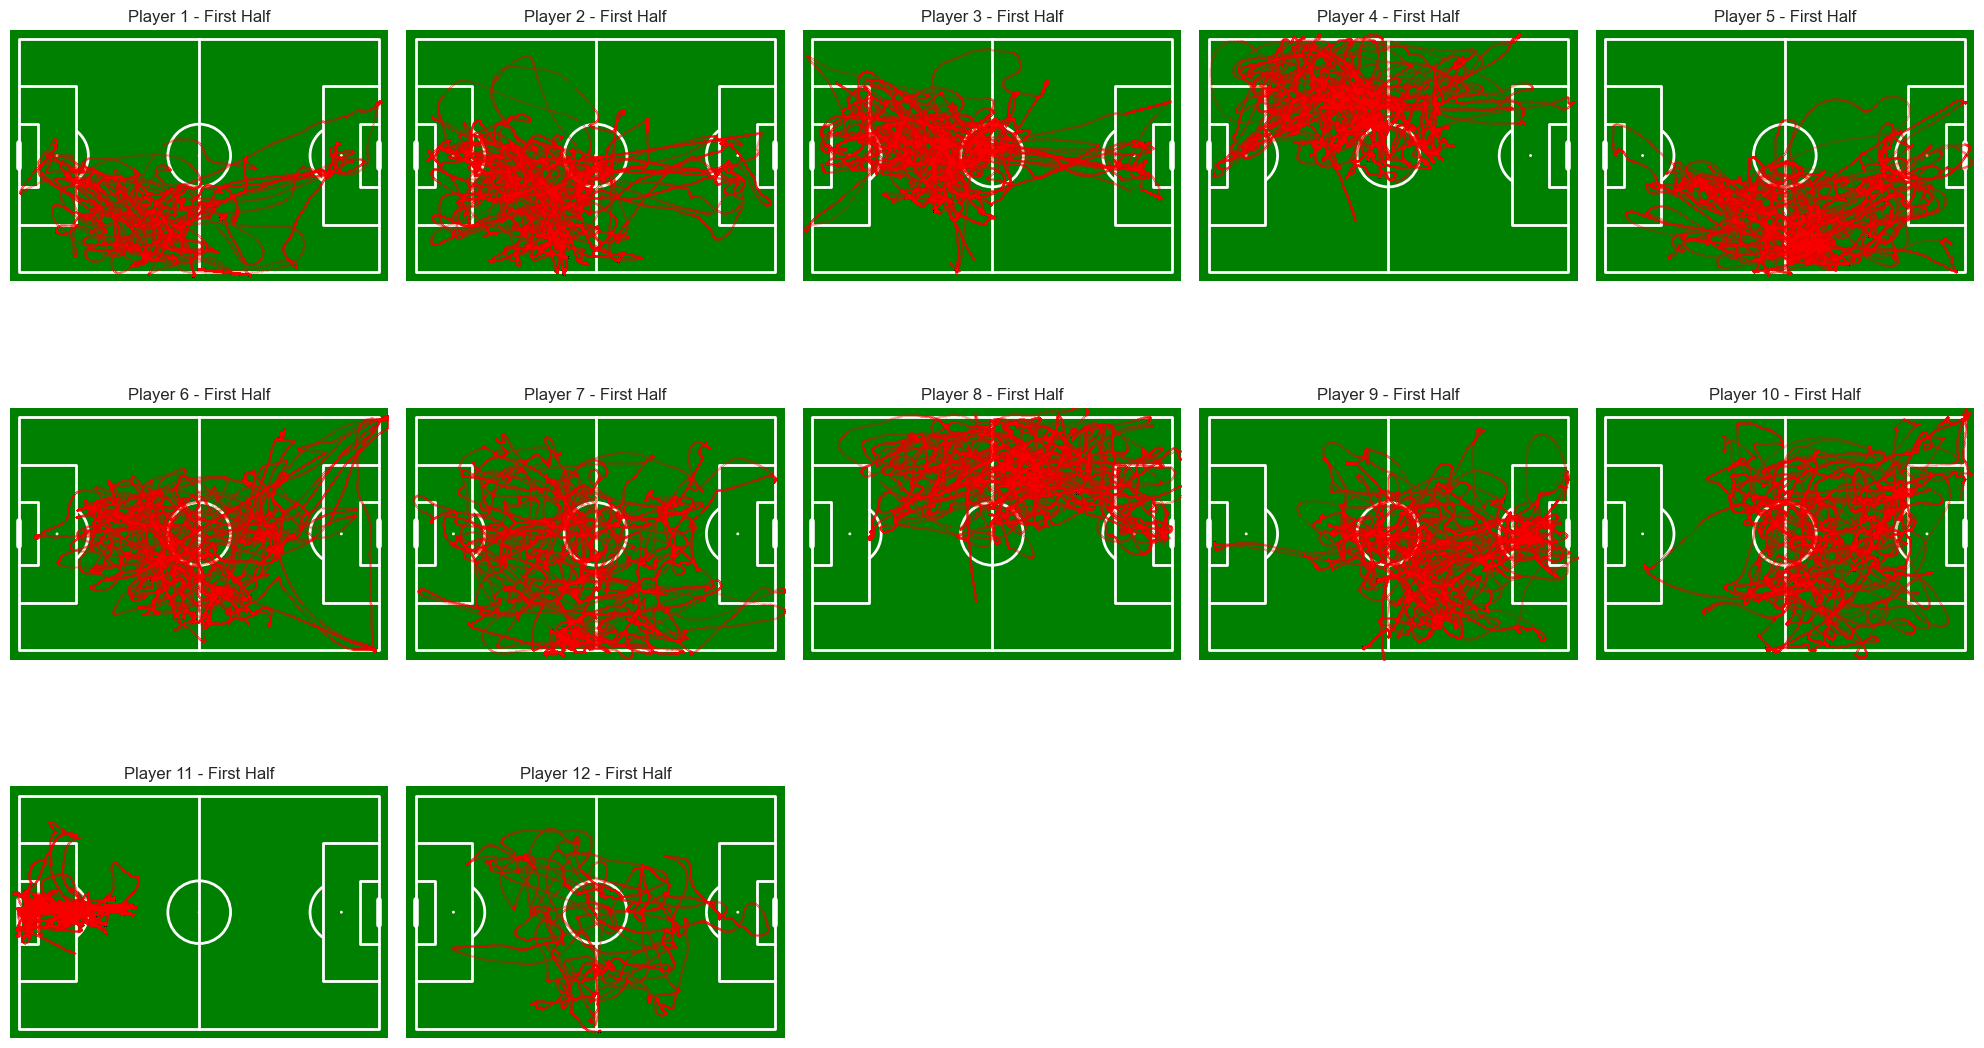

In [77]:
# Create subplots for each player (First Half Only)
first_half = game_1_home_team[game_1_home_team['Period'] == 1]

figure, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i in range(1, 13): 
    try:
        # Create individual pitch for each player
        football_pitch = Pitch(pitch_type='metricasports', pitch_length=105, pitch_width=68, line_color='white', pitch_color='green')
        football_pitch.draw(ax=axes[i-1])
        
        player_x = first_half[f'Player{i}_x'].dropna()
        player_y = first_half[f'Player{i}_y'].dropna()
        
        if len(player_x) > 0:
            football_pitch.scatter(player_x, player_y, ax=axes[i-1], s=0.01, color='red')
            axes[i-1].set_title(f'Player {i} - First Half', fontsize=12)
    except KeyError:
        axes[i-1].set_title(f'Player {i} - No Data', fontsize=12)

# Remove empty subplots (player 13/14 did not play in the first half)
for i in range(12, 15):
    figure.delaxes(axes[i])

plt.tight_layout()
plt.show()

- With a general idea of how the pitch is structured and how the data is plotted, we can now make some deductions, for example a player that remains fully near the Goal-area and his x-values variance is incredibly low will be a goalkeeper, using this logic we can apply it to the rest of the pitch, and deduce which areas each player is attacking the most. Resulting in 4 different areas:
- GK Area
- DF Area
- MID Area
- ATT Area

In [78]:
# Get first half data
first_half = game_1_home_team[game_1_home_team['Period'] == 1]

# Define area thresholds
def classify_position(x, y):
    if x < 0.2:
        if y >= 0.3 and y <= 0.7:
            return "GK Area"
        else:
            return "DF Area"
    elif x < 0.5:
        return "DF Area"
    elif x < 0.75:
        if y < 0.3 or y > 0.7:
            return "ATT Area"
        else:
            return "MID Area"
    else:
        return "ATT Area"

area_data = {"GK Area": 0, "DF Area": 0, "MID Area": 0, "ATT Area": 0}
player_areas = {}

for i in range(1, 13): 
    try:
        player_x = first_half[f'Player{i}_x'].dropna()
        player_y = first_half[f'Player{i}_y'].dropna()
        
        if len(player_x) > 0:
            player_area_total = {"GK Area": 0, "DF Area": 0, "MID Area": 0, "ATT Area": 0}
            # Creating X/Y co-ordinates using the zip function
            for x, y in zip(player_x, player_y):
                area = classify_position(x, y)
                player_area_total[area] += 1
                area_data[area] += 1
            
            player_areas[f'Player{i}'] = player_area_total
    except KeyError:
        continue

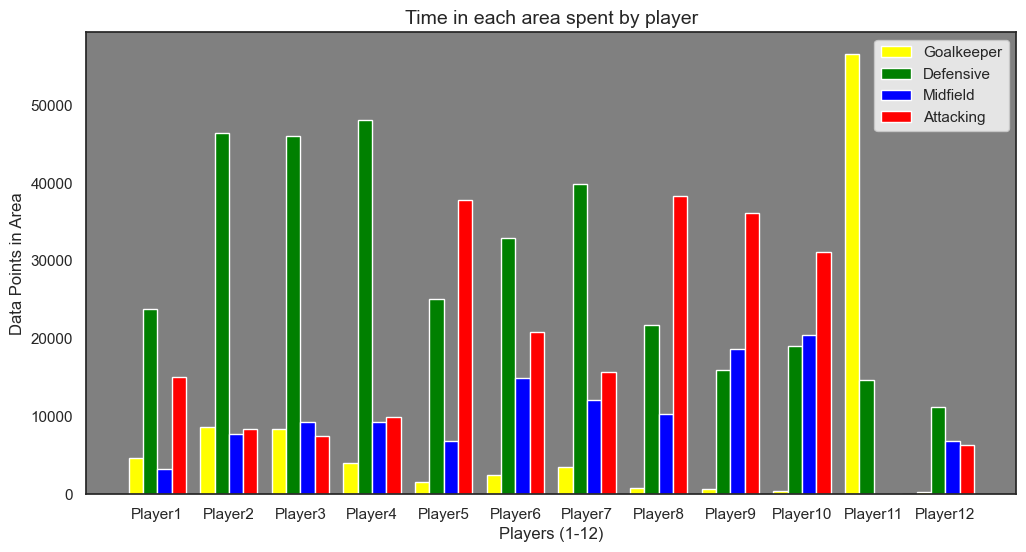

In [79]:
# Acquire each player
player_names = list(player_areas.keys())
# Find the time spent in each area for all players
gk_time = [player_areas[p]["GK Area"] for p in player_names]
df_time = [player_areas[p]["DF Area"] for p in player_names]
mid_time = [player_areas[p]["MID Area"] for p in player_names]
att_time = [player_areas[p]["ATT Area"] for p in player_names]

# We need 4 bars per player
bar = range(len(player_names))
width = 0.2 #Distance between each bar

plt.figure(figsize=(12, 6))
plt.bar([x - (1.5*width) for x in bar], gk_time, width, label='Goalkeeper', color='yellow') #First bar (GK)
plt.bar([x - (0.5*width) for x in bar], df_time, width, label='Defensive', color='green') #Second bar (DF)
plt.bar([x + (0.5*width) for x in bar], mid_time, width, label='Midfield', color='blue') # Third bar (MID)
plt.bar([x + (1.5*width) for x in bar], att_time, width, label='Attacking', color='red') # Fourth bar (ATT)
plt.title('Time in each area spent by player', fontsize=14)
plt.ylabel('Data Points in Area')
plt.xlabel('Players (1-12)')
plt.xticks(bar, player_names)
plt.legend()
# Setting the background color of the plot
ax = plt.gca()
ax.set_facecolor("grey")
plt.show()

The histogram gives us the amount of data points for each player in the four positions we made available with the formula of earlier. As seen, from the heatmap we were able assume that Player 11 was a Goalkeeper which the histogram strongly supports. 
We need to try classify further games now, but first our algorithm needs a detection system that which side of the pitch we are analysing, and make further use of Y co-ordinates and their variance, to try and accurately predict positions. 

In [80]:
def predict_player_position(player_name, first_half_data):
    """Predict player position based on X, Y coordinates and variance"""
    
    # Get player coordinates
    player_x = first_half_data[f'{player_name}_x'].dropna()
    player_y = first_half_data[f'{player_name}_y'].dropna()
    
    # Calculate metrics
    avg_x = player_x.mean()
    avg_y = player_y.mean()
    x_variance = player_x.var()
    y_variance = player_y.var()
    
    # Primary classification based on X-coordinate
    if avg_x < 0.2:
        # Goalkeeper area - check if actually goalkeeper
        if avg_y >= 0.3 and avg_y <= 0.7 and x_variance < 0.01 and y_variance < 0.05:
            position = "Goalkeeper"
        else:
            position = "Defender"  # Fallback for defensive players near goal
    elif avg_x < 0.5:
        # Defensive area
        position = "Defender"
    elif avg_x < 0.65:
        # Midfield/Attacking area - use Y-coordinate to distinguish
        if avg_y < 0.3 or avg_y > 0.6:  # Wide positions (wingers/wide attackers)
            position = "Attacker"
        else:
            position = "Midfielder"  # Central midfielders
    else:
        # Attacking area
        position = "Attacker"
    
    return {
        'player': player_name,
        'avg_x': avg_x,
        'avg_y': avg_y,
        'x_variance': x_variance,
        'y_variance': y_variance,
        'predicted_position': position
    }


In [81]:
def predict_player_position(player_name, first_half_data, side='left'):
    """Predict player position based on X, Y coordinates and side"""
    
    player_x = first_half_data[f'{player_name}_x'].dropna()
    player_y = first_half_data[f'{player_name}_y'].dropna()
    
    avg_x = player_x.mean()
    avg_y = player_y.mean()
    x_variance = player_x.var()
    y_variance = player_y.var()
    
    if side == 'left':
        # Left side: low X = defensive, high X = attacking
        if avg_x < 0.2:
            if avg_y >= 0.3 and avg_y <= 0.7 and x_variance < 0.01:
                position = "Goalkeeper"
            else:
                position = "Defender"
        elif avg_x < 0.5:
            position = "Defender"
        elif avg_x < 0.65:
            if avg_y < 0.3 or avg_y > 0.6:
                position = "Attacker"
            else:
                position = "Midfielder"
        else:
            position = "Attacker"
    else:  # right side
        # Right side: high X = defensive, low X = attacking (INVERTED)
        if avg_x > 0.8:
            if avg_y >= 0.3 and avg_y <= 0.7 and x_variance < 0.01:
                position = "Goalkeeper"
            else:
                position = "Defender"
        elif avg_x > 0.5:
            position = "Defender"
        elif avg_x > 0.35:
            if avg_y < 0.3 or avg_y > 0.6:
                position = "Attacker"
            else:
                position = "Midfielder"
        else:
            position = "Attacker"
    
    return {
        'player': player_name,
        'avg_x': avg_x,
        'avg_y': avg_y,
        'x_variance': x_variance,
        'y_variance': y_variance,
        'predicted_position': position
    }

predict_player_position('Player5', first_half)

{'player': 'Player5',
 'avg_x': np.float64(0.559004591541786),
 'avg_y': np.float64(0.7413299642195655),
 'x_variance': np.float64(0.03766818797065415),
 'y_variance': np.float64(0.021712010728109906),
 'predicted_position': 'Attacker'}

In [82]:
def analyze_all_players_positions():
    """Analyze all players and predict their positions"""
    
    # Get first half data
    first_half = game_1_home_team[game_1_home_team['Period'] == 1]
    
    # List of all players
    players = ['Player1', 'Player2', 'Player3', 'Player4', 'Player5', 
               'Player6', 'Player7', 'Player8', 'Player9', 'Player10', 
               'Player11', 'Player12']
    
    results = []
    
    for player in players:
        try:
            result = predict_player_position(player, first_half)
            results.append(result)
            
            # Print individual results
            print(f"{player}: {result['predicted_position']} "
                  f"(X: {result['avg_x']:.3f}, Y: {result['avg_y']:.3f}, "
                  f"X_var: {result['x_variance']:.3f})")
                  
        except KeyError:
            print(f"{player}: No data available")
    
    return results

# Run the analysis
print("=== PLAYER POSITION PREDICTIONS (First Half) ===")
all_predictions = analyze_all_players_positions()

# Summary by position
print("\n=== POSITION SUMMARY ===")
position_counts = {}
for result in all_predictions:
    pos = result['predicted_position']
    position_counts[pos] = position_counts.get(pos, 0) + 1

for position, count in position_counts.items():
    print(f"{position}: {count} players")

=== PLAYER POSITION PREDICTIONS (First Half) ===
Player1: Defender (X: 0.442, Y: 0.749, X_var: 0.043)
Player2: Defender (X: 0.397, Y: 0.653, X_var: 0.038)
Player3: Defender (X: 0.403, Y: 0.488, X_var: 0.043)
Player4: Defender (X: 0.415, Y: 0.303, X_var: 0.029)
Player5: Attacker (X: 0.559, Y: 0.741, X_var: 0.038)
Player6: Midfielder (X: 0.515, Y: 0.541, X_var: 0.039)
Player7: Defender (X: 0.470, Y: 0.629, X_var: 0.034)
Player8: Attacker (X: 0.589, Y: 0.259, X_var: 0.042)
Player9: Midfielder (X: 0.647, Y: 0.576, X_var: 0.033)
Player10: Midfielder (X: 0.621, Y: 0.514, X_var: 0.027)
Player11: Goalkeeper (X: 0.125, Y: 0.487, X_var: 0.007)
Player12: Midfielder (X: 0.525, Y: 0.569, X_var: 0.027)

=== POSITION SUMMARY ===
Defender: 5 players
Attacker: 2 players
Midfielder: 4 players
Goalkeeper: 1 players


Football is a game of tactics, and the game changes constantly, there are advanced positions such as:
- Wing-backs: Defenders that go forward into attacking spaces, resulting in skewed time variances
- Defensive Midfielders: Some midfielders drop deep into defence, to support the defence in transitions, again affecting their time spent in midfield against defence.
- Tactics: There are various tactics that result in skewed results, A famous tactic right now would be the high-line adopted by FC Barcelona instilled by Hansi Flick, The high line makes the defence come up all the way to the half-way line, and results in a full-on press by both midfielders and attackers, the other team has no choice but to come up with FC Barcelona when they are in possession of the ball, this tactic will completely skew 

Conclusion

This study explored the feasibility of predicting football player positions using tracking data from Metrica Sports. By analysing X and Y coordinates, variance, and time spent in different pitch areas, we developed an algorithm capable of classifying players into four main roles: Goalkeeper, Defender, Midfielder, and Attacker.

Key Findings

- Goalkeeper Detection: The algorithm successfully identified the goalkeeper (Player 11) with high accuracy, using low X-variance and central Y-positioning as key indicators. This serves as an anchor point for understanding which side of the pitch a team is playing from.
- Position Classification: Using coordinate averages and variance analysis, we achieved reasonable predictions for the first half of Sample Game 1, resulting in 1 Goalkeeper, 5 Defenders, 4 Midfielders, and 2 Attackers.
- Side Detection: By analysing the goalkeeper's average X-position (0.125), we confirmed the home team started from the left side of the pitch in the first half, allowing us to correctly orient our position predictions.

Limitations

- Tactical Fluidity: Football tactics vary significantly between teams and matches. Roles like wing-backs and defensive midfielders blur the lines between traditional positions, making rigid classification challenging.
- Game State Impact: Player positions shift based on ball possession, set pieces, and scoreline. A defender during a corner kick will appear in attacking areas, skewing the data.
- Substitutes: Players 13 and 14 had no first-half data as substitutes, limiting our analysis to the starting eleven plus one substitute (Player 12).

Future Improvements

- Incorporate ball position data to filter out set-piece situations
- Add time-weighted analysis to account for different game phases
- Use clustering algorithms (K-Means) to group players by movement patterns rather than fixed thresholds
- Extend analysis across multiple matches to validate predictions against known formations